I need to work out how much DV is saved by gravity assists on the way into the Jovian system.
I could make a proper gravity assist helper. That seems tough. 
### Ideas for proper gravity assist calculator
The first test will be how effective this plotter is at predicting the Jupiter-Saturn gravity assists taken by Pioneer and Voyager.\\
\\
A naive idea is to take some number (maybe as low as 10) different trajectories through the Jupiter system, and propagate them to see how close they get to Saturn

In [2]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [15]:
print(Jupiter.R.to(u.km))

71492.0 km


Test code for Jovian system 

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



The Starship is in a 137500 x 10862500 km x 0.0 deg (JupiterICRS) orbit around Jupiter (♃) at epoch 2037-07-18 01:02:09.184 (TDB).
The period is 83.32973111652454 d.
Speed at periapsis is 42.66 km / s, which is 269 m / s below escape velocity at that altitude.
Burn of 2.90 km/s applied to reduce speed at periapsis.


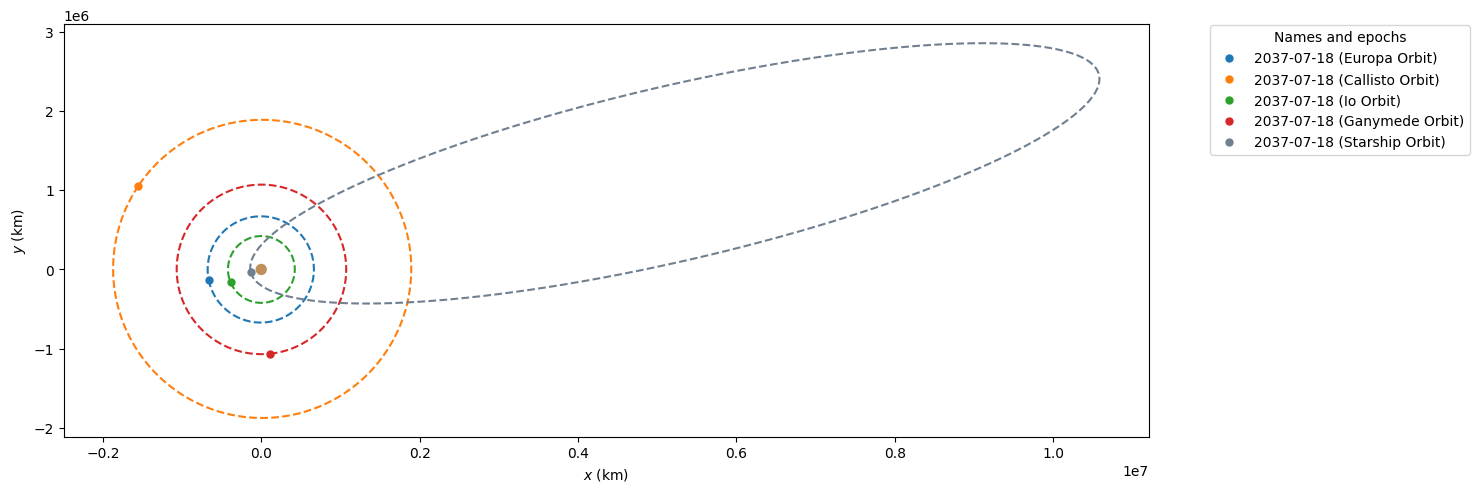

In [18]:
start_date = time.Time("2037-07-18 01:01", scale="utc").tdb
end_date = time.Time("2037-07-25 01:01", scale="utc").tdb

body1=Europa
plotter = StaticOrbitPlotter()
starship_orb=Orbit.from_classical(Jupiter, 5500000*u.km, 0.975*u.one, 0*u.deg, 0*u.deg, 0*u.deg, 0*u.deg,start_date)


epoch=time_range(start=start_date, end=end_date)
io_ephem = Ephem.from_horizons(501,epochs= epoch, attractor= Jupiter)#Io is 501
ganymede_ephem = Ephem.from_horizons(503,epochs= epoch, attractor= Jupiter)#Ganymede is 503
europa_ephem = Ephem.from_horizons(502,epochs= epoch, attractor= Jupiter)#Europa is 592
callisto_ephem = Ephem.from_horizons(504,epochs= epoch, attractor= Jupiter)

orb_europa = Orbit.from_ephem(Jupiter, europa_ephem, start_date)
orb_callisto = Orbit.from_ephem(Jupiter, callisto_ephem, start_date)
orb_io = Orbit.from_ephem(Jupiter, io_ephem, start_date)
orb_ganymede = Orbit.from_ephem(Jupiter, ganymede_ephem, start_date)

#apply retrograde burn to slow elliptical orbit to one closer to Europa orbit speed
prograde_vector = (starship_orb.v/(np.linalg.norm(starship_orb.v))).value
burn_dv = -2.90*prograde_vector#km/s

retro_burn = Maneuver((0*u.s,burn_dv*u.km/u.s))
post_burn_orbit = starship_orb.apply_maneuver(retro_burn)
post_burn_orbit=post_burn_orbit.propagate_to_anomaly(math.pi*u.rad)

# #apply retrograde burn to speed elliptical orbit to one closer to Europa orbit speed
# prograde_vector = (starship_orb.v/(np.linalg.norm(starship_orb.v))).value
# burn_dv = -3.10*prograde_vector#km/s


plotter.plot(orb_europa, label="Europa Orbit")
plotter.plot(orb_callisto, label="Callisto Orbit")
plotter.plot(orb_io, label="Io Orbit")
plotter.plot(orb_ganymede, label="Ganymede Orbit")
# plotter.plot_ephem(ephem, label="Europa Orbit")

#Galelio orbit starship_orb=Orbit.from_classical(Jupiter, 8500000*u.km, 0.975*u.one, 0*u.deg, 0*u.deg, 0*u.deg, 0*u.deg,start_date)
plotter.plot(starship_orb, color="slategrey",label="Starship Orbit")
# plotter.plot(post_burn_orbit, color="red",label="Post Retro Burn Orbit")
print(f"The Starship is in a {starship_orb}.")
print(f"The period is {starship_orb.period.to(u.day)}.")
# print(Jupiter.R)

#iffy function that only works if the above orbit definition puts the spacecraft at periapsis
evel = Jupiter.escape_velocity_at_alt( np.linalg.norm(starship_orb.r) - Jupiter.R)
pvel = np.linalg.norm(starship_orb.v.to(u.km/u.s))

print(f"Speed at periapsis is {pvel:.2f}, which is {(evel-pvel):.0f} below escape velocity at that altitude.")
print(f"Burn of {np.linalg.norm(burn_dv):.2f} km/s applied to reduce speed at periapsis.")



/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



The Starship is in a 82500 x 674264 km x 0.0 deg (JupiterICRS) orbit around Jupiter (♃) at epoch 2037-07-15 19:04:47.634 (TDB).
The period is 1.5036678223692446 d.
-7.290350632886649 km / s


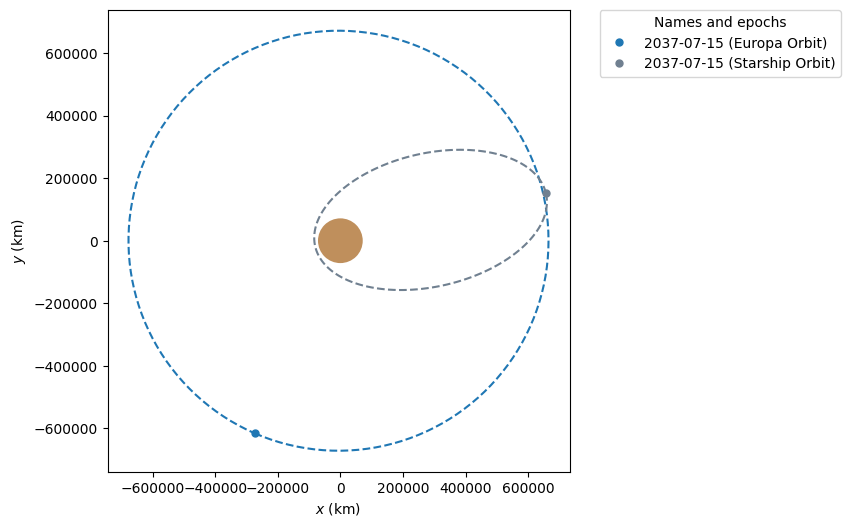

In [4]:
#From that orbit, how much DV to land on Europa?
#its not obvious how reducing the orbit down with g assists would be calculated, but lets assume we can get to
#roughly callisto apogee, europa perigee
start_date = time.Time("2037-07-17 14:01", scale="utc").tdb
end_date = time.Time("2037-07-25 01:01", scale="utc").tdb

epoch=time_range(start=start_date, end=end_date)

europa_ephem = Ephem.from_horizons(502,epochs= epoch, attractor= Jupiter)#Europa is 592

body1=Europa

plotter = StaticOrbitPlotter()

plotter.plot(orb_europa, label="Europa Orbit")

starship_orb=post_burn_orbit
#Galelio orbit starship_orb=Orbit.from_classical(Jupiter, 8500000*u.km, 0.975*u.one, 0*u.deg, 0*u.deg, 0*u.deg, 0*u.deg,start_date)
# starship_orb=Orbit.from_classical(Jupiter, 700000*u.km, 0.075*u.one, 0*u.deg, 0*u.deg,55*u.deg, 0*u.deg,start_date)
plotter.plot(starship_orb, color="slategrey",label="Starship Orbit")
print(f"The Starship is in a {starship_orb}.")
print(f"The period is {starship_orb.period.to(u.day)}.")
# print(Jupiter.R)

psped = np.linalg.norm(starship_orb.v.to(u.km/u.s))
europa_sped = np.linalg.norm(orb_europa.v.to(u.km/u.s))
print(psped-europa_sped)
# print(f"Speed at periapsis is {pvel:.2f}, Europa orbital velocity at that point is {np.linalg.norm(europa_vel.to(u.km/u.s)):.2f} km/s")


The arrival $V_\infty$ at Europa will just be the perigee velocity subtracted by Europa orbital velocity at that point. We can then propagate the trajectory in patched conic form (perhaps with Jovian pertubation, will be interesting to compare with and without) to calculate insertion $\Delta V$.

I'm suspicious of the above (it seems to have a very arrival velocity), but will see.

Arrival speed (at periapsis) is 7.567468571528906 km / s
EOI burn with 6.16 km / s delta-V.
Final orbit velocity is 1.4100674772998854 km / s


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 150 of "dubious year (Note 4)"



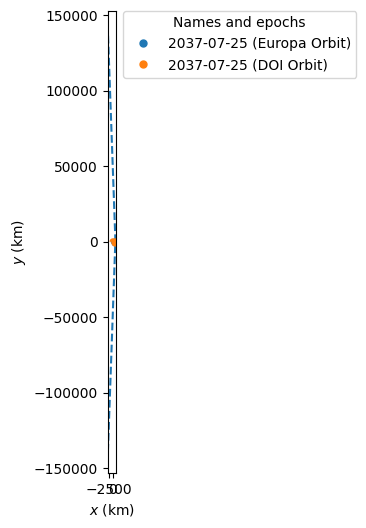

In [5]:
v_sc_arriv = 7.3*u.km/u.s

c3_a = np.linalg.norm(v_sc_arriv)**2

#C3 only orbit calc
r_p = 50*u.km#arrival periapsis
a_exit = -(body1.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body1.R) / a_exit

arrival_orbit = Orbit.from_classical(
    body1,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(end_date, scale="utc"),
)
arrival_circular_orbit = Orbit.circular(body1,alt = r_p, epoch=time.Time(end_date, scale="utc"))
EOI_DV = np.linalg.norm(arrival_orbit.v)-np.linalg.norm(arrival_circular_orbit.v)

print(f"Arrival speed (at periapsis) is {np.linalg.norm(arrival_orbit.v)}")
print(f"EOI burn with {EOI_DV:.2f} delta-V.")
print(f"Final orbit velocity is {np.linalg.norm(arrival_circular_orbit.v)}")


plotter = StaticOrbitPlotter()

plotter.plot(arrival_orbit, label="Europa Orbit")
plotter.plot(arrival_circular_orbit, label="DOI Orbit")

Calculating the landing $\Delta V$ will be harder -- Starship has a huge TwR on Europa, which probably helps it quite a bit $\Delta V$ wise, except for its total inability to hover. The HLS landing engines could come in helpful, though we know nothing about them.
If we simulate the engines being on with pure retrograde thrust we can 


In [6]:
#0th order GPE + Orbital velocity
g=1.612
m=1.45e4



h=110e3
g_vel = (2*(g*h))**0.5
print(g_vel+1600)
##Little test with lunar numbers

2195.51658247273


This method has serious problems as the extra DV bit to make up for gravity losses is completely dependant on parking orbit altitude. Hmm. 
I want to do this dumbly and naively. Perhaps the parking orbit can be calculated 

In [7]:
#Yes - I can calcualte gravity losses from the time it takes to complete the burn